# 1. Introduction

## Hindenburg–Adani Contagion & Curing Model

In this notebook:
Implements a Polya-based contagion model for negative sentiment spreading across four categories of investors:
1. **Promoters (8083 nodes)**  
2. **Foreign Institutional Investors (FII) (2209 nodes)**  
3. **Public (978 nodes)**  
4. **Mutual Funds (221 nodes)**  
 - *Possible scaling of nodes*

We tailor our connections as follows:
- **Promoters** are fully connected to the **Public**.
- **Mutual Funds** are partially (≈50%) connected to **FII** and partially to **Promoters + Public**.
- **Memory** of 90 time steps is used (older draws fade after 90 steps).
- **Initial Sentiment**: Each category has a baseline red (negative) to black (positive) ratio, but we add ±2% random variation per node.
- **Shock**: 10,000 red balls per time step are introduced into the FII, Public, and Mutual Funds for the first 10 time steps.
- **Heuristic Curing**: A Greedy Adaptive Heuristic (GAH) injects black balls into high-risk nodes to mitigate contagion.

We will:
- Construct the network with custom edges.
- Run multi-trial simulations of both contagion and curing.
- Visualize outcomes via line charts, heatmaps, time-lapse network snapshots, and subplots.
- Perform a sensitivity analysis on the curing parameters to assess trade-offs between cost and containment.


# 2. Imports / Initialization

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)

sns.set_style("whitegrid")

In [37]:
import scipy
print(scipy.__version__)

1.7.3


In [38]:
import sys
print(sys.executable)

C:\Users\heyet\OneDrive\Documents\Anaconda\python.exe


# 3. Parameters and Network Construction

In [39]:
def build_hindenburg_adani_network():
    G = nx.Graph()
    
    # 8083, 2209, 978, 221
    
    offset = 0
    promoters_nodes = list(range(offset, offset+160))
    offset += 160
    fii_nodes = list(range(offset, offset+45))
    offset += 45
    public_nodes = list(range(offset, offset+20))
    offset += 20
    mf_nodes = list(range(offset, offset+4))
    offset += 4
    
    for n in promoters_nodes:
        G.add_node(n, category='Promoters')
    for n in fii_nodes:
        G.add_node(n, category='FII')
    for n in public_nodes:
        G.add_node(n, category='Public')
    for n in mf_nodes:
        G.add_node(n, category='MutualFunds')
    
    # 1) Promoters <-> Public (fully connected)
    for p in promoters_nodes:
        for pub in public_nodes:
            G.add_edge(p, pub)
    
    # 2) Mutual Funds partial connectivity
    #    Each MF node connects to ~50% of FII and ~50% of Promoters+Public
    promoters_public_combined = promoters_nodes + public_nodes
    
    for mf in mf_nodes:
        half_fii_count = len(fii_nodes) // 2
        fii_subset = np.random.choice(fii_nodes, size=half_fii_count, replace=False)
        
        half_pp_count = len(promoters_public_combined) // 2
        pp_subset = np.random.choice(promoters_public_combined, size=half_pp_count, replace=False)
        
        for f_node in fii_subset:
            G.add_edge(mf, f_node)
        for pp_node in pp_subset:
            G.add_edge(mf, pp_node)
    
    return G

In [40]:
G_base = build_hindenburg_adani_network()
print("Nodes:", G_base.number_of_nodes(), "Edges:", G_base.number_of_edges())

Nodes: 229 Edges: 3648


In [41]:
def draw_adani_network_topology(G, pos=None, filename="adani_network_topology.png"):
    """
    Draw the network color-coded by category:
      - Promoters   -> darkred
      - FII         -> gold
      - Public      -> lightskyblue
      - MutualFunds -> limegreen
    
    If pos is None, uses spring_layout for a fixed layout.
    """
    if pos is None:
        pos = nx.kamada_kawai_layout(G)
    
    # Separate nodelists by category
    promoters = [n for n in G.nodes() if G.nodes[n]["category"] == "Promoters"]
    fii = [n for n in G.nodes() if G.nodes[n]["category"] == "FII"]
    public = [n for n in G.nodes() if G.nodes[n]["category"] == "Public"]
    mfunds = [n for n in G.nodes() if G.nodes[n]["category"] == "MutualFunds"]
    
    plt.figure(figsize=(10, 8))
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    
    # Draw nodes by group
    nx.draw_networkx_nodes(G, pos, nodelist=promoters, node_color="darkred", 
                           node_size=20, label="Promoters")
    nx.draw_networkx_nodes(G, pos, nodelist=fii, node_color="gold", 
                           node_size=20, label="FII")
    nx.draw_networkx_nodes(G, pos, nodelist=public, node_color="lightskyblue", 
                           node_size=20, label="Public")
    nx.draw_networkx_nodes(G, pos, nodelist=mfunds, node_color="limegreen", 
                           node_size=20, label="MutualFunds")
    
    plt.title("Adani Network Topology (Promoters, FII, Public, MutualFunds)")
    plt.axis("off")
    plt.legend(scatterpoints=1, loc="best")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

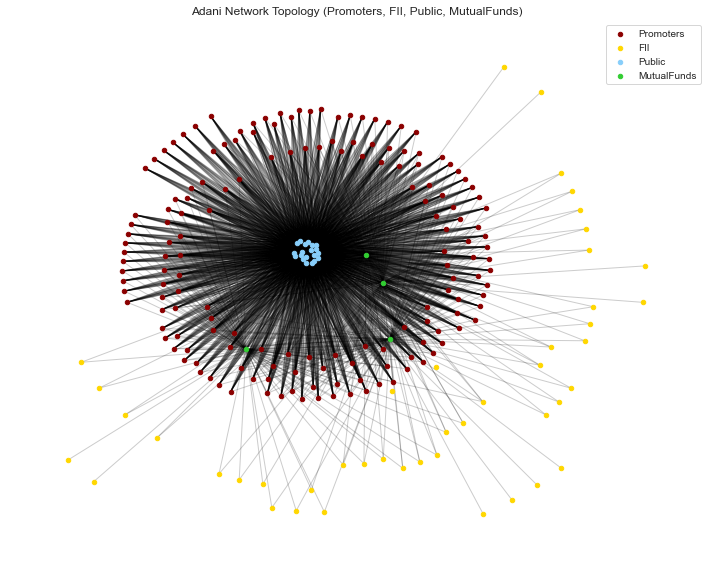

In [42]:
pos = nx.kamada_kawai_layout(G_base)
draw_adani_network_topology(G_base, pos, filename="adani_network_topology_100nodes.png")

# 4. Initial Sentiment / Memory

In [76]:
def assign_initial_sentiment_random(G, variation=0.02, total_balls=100):
    """
    Returns:
      - black_counts: dict[node] -> int
      - red_counts: dict[node] -> int
      - alphas: dict[node] -> float (random reinforcement factor)
    Each category has a 'base' ratio, plus ± variation from Uniform(-variation, variation).
    """
    black_counts = {}
    red_counts = {}
    alphas = {}
    
    base_ratios = {
        'Promoters': 0.90,     # 90% black, 10% red
        'FII': 0.80,
        'Public': 0.80,
        'MutualFunds': 0.80
    }
    
    alpha_min = 5
    alpha_max = 15
    
    for n in G.nodes():
        cat = G.nodes[n]['category']
        base_black = base_ratios[cat]
        
        delta = np.random.uniform(-variation, variation)
        ratio = np.clip(base_black + delta, 0, 1)
        
        b_count = int(ratio * total_balls)
        r_count = total_balls - b_count
        
        black_counts[n] = b_count
        red_counts[n] = r_count
        
        alphas[n] = np.random.uniform(alpha_min, alpha_max)
    
    return black_counts, red_counts, alphas

# 5. Contagion with Shock

In [77]:
def polya_contagion_step(G, black_counts, red_counts, alphas):
    for n in G.nodes():
        total = black_counts[n] + red_counts[n]
        if total > 0:
            p_red = red_counts[n] / total
            if np.random.rand() < p_red:
                red_counts[n] += int(alphas[n])
    return black_counts, red_counts

In [95]:
def apply_random_shock(G, black_counts, red_counts, shock_prob=0.1,
                       shock_subset_fraction=0.1,
                       shock_min=500, shock_max=750):
    """
    With probability shock_prob, we add a random number of red balls (in [shock_min, shock_max])
    to shock_subset_fraction of the nodes.
    """
    if np.random.rand() < shock_prob:
        # choose subset of nodes
        subset_size = int(len(G.nodes()) * shock_subset_fraction)
        subset_nodes = np.random.choice(list(G.nodes()), size=subset_size, replace=False)
        shock_magnitude = np.random.randint(shock_min, shock_max+1)
        
        for n in subset_nodes:
            red_counts[n] += shock_magnitude
    
    return black_counts, red_counts

# 6. GAH Curing

In [96]:
def compute_red_ratio(G, black_counts, red_counts):
    ratio = {}
    for n in G.nodes():
        total = black_counts[n] + red_counts[n]
        ratio[n] = (red_counts[n]/total) if total>0 else 0
    return ratio

In [97]:
def apply_gah_curing(G, black_counts, red_counts, top_k_percent=0.25, black_injection=15000):
    """
    1. Compute fraction red for each node
    2. Sort by descending red ratio
    3. Inject black_injection black balls into top k%
    """
    ratios = compute_red_ratio(G, black_counts, red_counts)
    sorted_nodes = sorted(ratios, key=lambda x: ratios[x], reverse=True)
    top_k = int(len(sorted_nodes) * top_k_percent)
    high_risk = sorted_nodes[:top_k]
    
    for n in high_risk:
        black_counts[n] += black_injection
    
    return black_counts, red_counts

# 7. Multi-Trial Sim

In [98]:
def run_node_level_simulation(
    G,
    n_steps=30,
    n_trials=5,
    shock_stop=20,
    shock_prob=0.1,
    shock_subset_fraction=0.1,
    shock_min=500,
    shock_max=750,
    cure_steps=range(20,70),
    top_k_percent=0.05,
    black_injection=1000,
    variation=0.02,
    total_balls=100
):
    """
    Similar to run_multi_trial_simulation, but logs each node's red ratio
    so we can group by category and plot lines for each node.
    """
    records = []  # will store dicts of {trial, step, node, category, red_ratio}
    
    for trial in range(n_trials):
        # Random initial sentiment
        black_counts, red_counts, alphas = assign_initial_sentiment_random(
            G, variation=variation, total_balls=total_balls
        )
        
        for t in range(n_steps):
            # Log each node
            for n in G.nodes():
                b = black_counts[n]
                r = red_counts[n]
                total = b + r
                red_ratio = r / total if total > 0 else 0
                records.append({
                    "trial": trial,
                    "step": t,
                    "node": n,
                    "category": G.nodes[n]["category"],
                    "red_ratio": red_ratio
                })
            
            # Optionally limit shocks before shock_stop
            if t < shock_stop:
                # e.g., if you want a direct injection of red
                # or you can keep using apply_random_shock below
                pass
            
            # apply random shock
            black_counts, red_counts = apply_random_shock(
                G, black_counts, red_counts,
                shock_prob=shock_prob,
                shock_subset_fraction=shock_subset_fraction,
                shock_min=shock_min,
                shock_max=shock_max
            )
            
            # polya step
            black_counts, red_counts = polya_contagion_step(G, black_counts, red_counts, alphas)
            
            # curing
            if t in cure_steps:
                black_counts, red_counts = apply_gah_curing(
                    G, black_counts, red_counts, 
                    top_k_percent=top_k_percent, 
                    black_injection=black_injection
                )
    
    df = pd.DataFrame(records)
    return df

In [104]:
def compute_global_red_ratio(G, black_counts, red_counts):
    total_red = sum(red_counts[n] for n in G.nodes())
    total_balls = sum(black_counts[n] + red_counts[n] for n in G.nodes())
    return (total_red / total_balls) if total_balls > 0 else 0

In [123]:
def run_node_level_simulation_with_metrics(
    G,
    n_steps=30,
    n_trials=5,
    shock_stop=20,
    shock_prob=0.1,
    shock_subset_fraction=0.1,
    shock_min=500,
    shock_max=750,
    cure_steps=range(20,70),
    top_k_percent=0.05,
    black_injection=1000,
    variation=0.02,
    total_balls=100,
    negativity_threshold=0.10
):
    """
    Similar to run_node_level_simulation, but tracks:
      - 'total_black_injected' per trial
      - 'time_to_containment' if the network's average negativity < negativity_threshold
      - final negativity spread
    """
    records = []
    summary_records = []  # store summary per trial
    
    for trial in range(n_trials):
        black_counts, red_counts, alphas = assign_initial_sentiment_random(G, variation=variation, total_balls=total_balls)
        
        total_black_injected = 0
        time_to_containment = None
        
        for t in range(n_steps):
            for n in G.nodes():
                b = black_counts[n]
                r = red_counts[n]
                total = b + r
                red_ratio = r / total if total > 0 else 0
                records.append({
                    "trial": trial,
                    "step": t,
                    "node": n,
                    "category": G.nodes[n]["category"],
                    "red_ratio": red_ratio
                })
            
            # Optionally limit shocks before shock_stop
            if t < shock_stop:
                # e.g., if you want a direct injection of red
                # or you can keep using apply_random_shock below
                pass
            
            # apply random shock
            black_counts, red_counts = apply_random_shock(
                G, black_counts, red_counts,
                shock_prob=shock_prob,
                shock_subset_fraction=shock_subset_fraction,
                shock_min=shock_min,
                shock_max=shock_max
            )
            
            # C) Polya update
            black_counts, red_counts = polya_contagion_step(G, black_counts, red_counts, alphas)
            
            # D) Curing
            if cure_steps and t in cure_steps:
                # measure how many black balls we add
                before_black = sum(black_counts.values())
                
                black_counts, red_counts = apply_gah_curing(
                    G, black_counts, red_counts,
                    top_k_percent=top_k_percent,
                    black_injection=black_injection
                )
                
                after_black = sum(black_counts.values())
                total_black_injected += (after_black - before_black)
            
            # E) Check if negativity is below threshold
            #    e.g. if average red ratio < negativity_threshold
            #    The earliest time we do this, store time_to_containment
            avg_red_ratio = compute_global_red_ratio(G, black_counts, red_counts)
            if avg_red_ratio < negativity_threshold and time_to_containment is None:
                time_to_containment = t
        
        # After n_steps, store final negativity
        final_negativity = compute_global_red_ratio(G, black_counts, red_counts)
        # Or you might store fraction of nodes above e.g. 0.5 red. Up to you.
        
        summary_records.append({
            "trial": trial,
            "time_to_containment": time_to_containment if time_to_containment is not None else n_steps,
            "final_negativity": final_negativity,
            "total_black_injected": total_black_injected
        })
    
    df_details = pd.DataFrame(records)
    df_summary = pd.DataFrame(summary_records)
    return df_details, df_summary


In [124]:
df_details, df_summary = run_node_level_simulation_with_metrics(
    G_base,
    n_steps=100,
    n_trials=5,
    shock_stop=20,
    shock_prob=0.1,
    shock_subset_fraction=0.1,
    shock_min=500,
    shock_max=750,
    cure_steps=range(20,70),
    top_k_percent=0.05,
    black_injection=1000,
    total_balls=100,
    negativity_threshold=0.2
)

In [125]:
df_summary

,trial,time_to_containment,final_negativity,total_black_injected
0,0,0,0.278390,550000
1,1,100,0.278547,550000
2,2,100,0.340085,550000
3,3,0,0.239160,550000
4,4,0,0.224197,550000


In [126]:
print("Average time to containment:", df_summary["time_to_containment"].mean())
print("Average final negativity:", df_summary["final_negativity"].mean())
print("Average black injection used:", df_summary["total_black_injected"].mean())


Average time to containment: 40.0
Average final negativity: 0.2720760382580732
Average black injection used: 550000.0


In [127]:
scenarios = [
    {"name": "Mild Cure", "black_injection": 1000, "top_k_percent": 0.05},
    {"name": "Moderate Cure", "black_injection": 3000, "top_k_percent": 0.1},
    {"name": "Strong Cure", "black_injection": 10000, "top_k_percent": 0.2},
]

all_summaries = []

for sc in scenarios:
    df_details, df_summary = run_node_level_simulation_with_metrics(
        G=G_base,
        n_steps=40,
        n_trials=5,
        shock_stop=20,
        shock_prob=0.3,
        shock_subset_fraction=0.2,
        shock_min=300,
        shock_max=1200,
        cure_steps=range(10, 31),  # Cure steps
        top_k_percent=sc["top_k_percent"],
        black_injection=sc["black_injection"],
        negativity_threshold=0.2
    )
    df_summary["scenario"] = sc["name"]
    all_summaries.append(df_summary)

df_final = pd.concat(all_summaries, ignore_index=True)
print(df_final.groupby("scenario").mean())


               trial  time_to_containment  final_negativity  \
scenario                                                      
Mild Cure        2.0                  8.0          0.622000   
Moderate Cure    2.0                  8.0          0.251885   
Strong Cure      2.0                  0.0          0.038495   

               total_black_injected  
scenario                             
Mild Cure                  231000.0  
Moderate Cure             1386000.0  
Strong Cure               9450000.0  


# 8. Network Snapshots

In [99]:
def draw_network_snapshot_sample(G, black_counts, red_counts, step, filename="snapshot.png"):
    import random
    
    all_nodes = list(G.nodes())
    if len(all_nodes) > 300:
        sample_nodes = np.random.choice(all_nodes, size=300, replace=False)
    else:
        sample_nodes = all_nodes
    
    subG = G.subgraph(sample_nodes).copy()
    
    node_colors = []
    for n in subG.nodes():
        b = black_counts[n]
        r = red_counts[n]
        total = b + r
        frac_red = r / total if total>0 else 0
        node_colors.append(frac_red)
    
    pos = nx.spring_layout(subG, seed=42)
    
    plt.figure(figsize=(10,8))
    nx.draw_networkx_nodes(subG, pos, node_color=node_colors, cmap="Reds", alpha=0.8, node_size=20)
    nx.draw_networkx_edges(subG, pos, alpha=0.2)
    plt.title(f"Network Snapshot (step={step})")
    plt.axis("off")
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    plt.colorbar(sm, label="Fraction Red")
    plt.savefig(filename, dpi=300)
    plt.show()

# 9. Heatmap

In [100]:
def sensitivity_analysis(G):
    shock_probs = [0.1, 0.3, 0.5]
    black_injs = [500, 1000, 2000]
    
    results = []
    for sp in shock_probs:
        for bi in black_injs:
            df_sens = run_multi_trial_simulation(
                G, n_steps=30, n_trials=3,
                shock_prob=sp,
                shock_subset_fraction=0.1,
                shock_min=500, shock_max=1500,
                cure_steps=range(20,70),
                top_k_percent=0.05,
                black_injection=bi
            )
            # final negativity
            final_df = df_sens[df_sens["step"] == 29]
            avg_final_red = final_df["avg_red_ratio"].mean()
            results.append({
                "shock_prob": sp,
                "black_injection": bi,
                "avg_final_red": avg_final_red
            })
    return pd.DataFrame(results)

def plot_sensitivity_heatmap(df_sens):
    pivoted = df_sens.pivot("shock_prob", "black_injection", "avg_final_red")
    plt.figure(figsize=(8,6))
    sns.heatmap(pivoted, annot=True, cmap="Reds", fmt=".3f")
    plt.title("Sensitivity Heatmap: Final Red Ratio vs. (Shock_Prob, Black_Injection)")
    plt.xlabel("Black Injection")
    plt.ylabel("Shock Probability")
    plt.tight_layout()
    plt.savefig("sensitivity_heatmap.png", dpi=300)
    plt.show()

# 10. Subplots & Tables

In [101]:
df_results = run_node_level_simulation(
    G_base,
    n_steps=100,
    n_trials=5,
    shock_stop=20,
    shock_prob=0.1,
    shock_subset_fraction=0.1,
    shock_min=500,
    shock_max=750,
    cure_steps=range(20,70),
    top_k_percent=0.05,
    black_injection=1000,
    variation=0.02,
    total_balls=100
)

df_results.head()

,trial,step,node,category,red_ratio
0,0,0,0,Promoters,0.10
1,0,0,1,Promoters,0.12
2,0,0,2,Promoters,0.12
3,0,0,3,Promoters,0.10
4,0,0,4,Promoters,0.09


In [102]:
def plot_adani_categories_over_time(df):
    """
    df: node-level DataFrame with columns [trial, step, node, category, red_ratio].
    We'll create 4 subplots: one for each category.
    """
    # For stable color usage across subplots
    category_colors = {
        "Promoters": "darkred",
        "FII": "gold",
        "Public": "lightskyblue",
        "MutualFunds": "limegreen"
    }
    
    categories = ["Promoters", "FII", "Public", "MutualFunds"]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
    axes = axes.flatten()  # easier to iterate over a 2x2 array
    
    for ax, cat in zip(axes, categories):
        # Filter to that category
        sub_df = df[df["category"] == cat]
        
        # Option 1: Plot each node's line across steps (averaging across trials or not).
        # If you want each node+trial line separately, do:
        for (node_id, trial_id), node_data in sub_df.groupby(["node", "trial"]):
            ax.plot(node_data["step"], node_data["red_ratio"], 
                    alpha=0.1, color=category_colors[cat])
        
        # Option 2: Add a bold line for the average ratio (across all nodes, all trials) at each step
        mean_data = sub_df.groupby("step")["red_ratio"].mean().reset_index()
        ax.plot(mean_data["step"], mean_data["red_ratio"], 
                color="black", linewidth=2, label=f"Mean {cat}")
        
        ax.set_title(f"{cat}")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Red Ratio")
        ax.set_ylim(0, 1)
        ax.legend()
    
    plt.suptitle("Red Ratio Over Time by Category (Adani Network)")
    sns.set_style("white") 
    plt.grid(axis='y', linestyle='--', color='red', linewidth=0.5)
    plt.tight_layout()
    plt.savefig("red_ratio_by_category.png", dpi=300)
    plt.show()

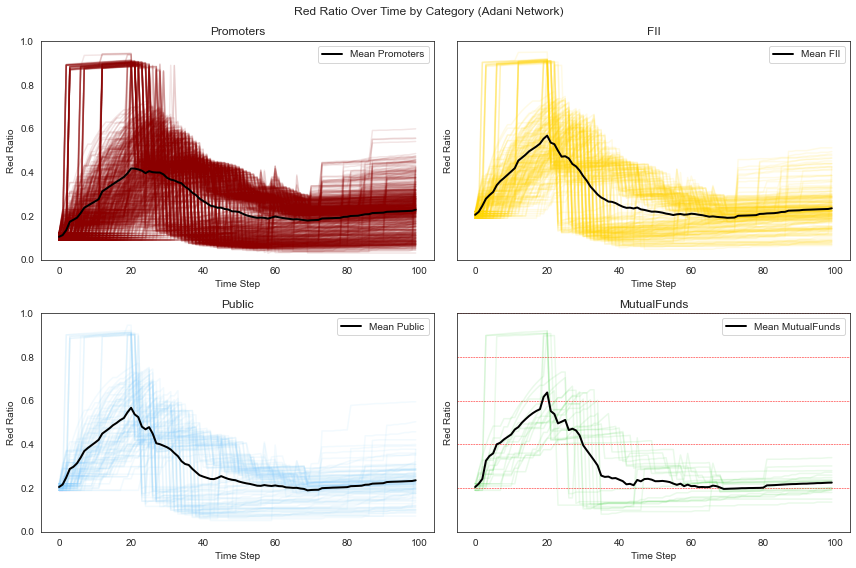

In [103]:
plot_adani_categories_over_time(df_results)

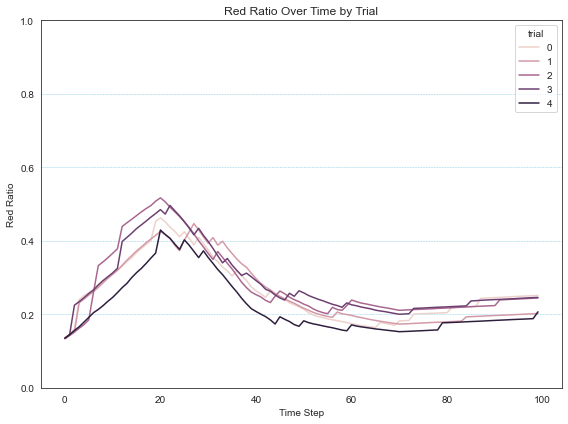

In [128]:
df_agg = df_results.groupby(["trial", "step"])["red_ratio"].mean().reset_index()

plt.figure(figsize=(8,6))
sns.lineplot(
    data=df_agg, 
    x="step", 
    y="red_ratio", 
    hue="trial", 
    estimator=None  
)
plt.title("Red Ratio Over Time by Trial")
plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Red Ratio")
sns.set_style("white") 
plt.grid(axis='y', linestyle='--', color='skyblue', linewidth=0.5)
plt.tight_layout()
plt.savefig("red_ratio_per_trial.png", dpi=300)
plt.show()

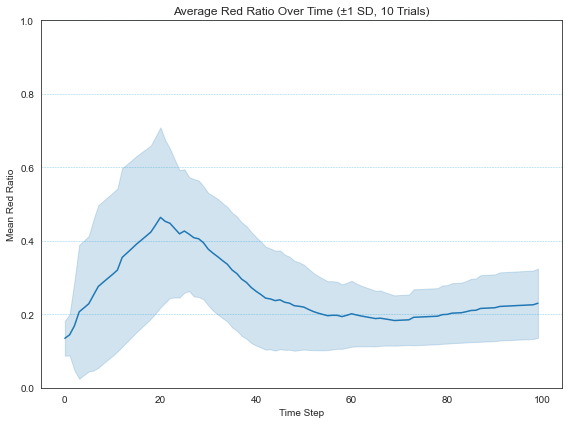

In [129]:
plt.figure(figsize=(8,6))
sns.lineplot(data=df_results, x="step", y="red_ratio", ci="sd")
plt.title("Average Red Ratio Over Time (±1 SD, 10 Trials)")
plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Mean Red Ratio")
sns.set_style("white") 
plt.grid(axis='y', linestyle='--', color='skyblue', linewidth=0.5)
plt.tight_layout()
plt.savefig("mean_red_ratio_sd.png", dpi=300)
plt.show()

### Figure X: Mean red ratio across 10 trials, with shaded ±1 standard deviation. Randomized shocks, 
### initial conditions, and node reinforcement factors lead to visibly distinct outcomes, highlighted by the 
### vertical spread of the confidence interval.

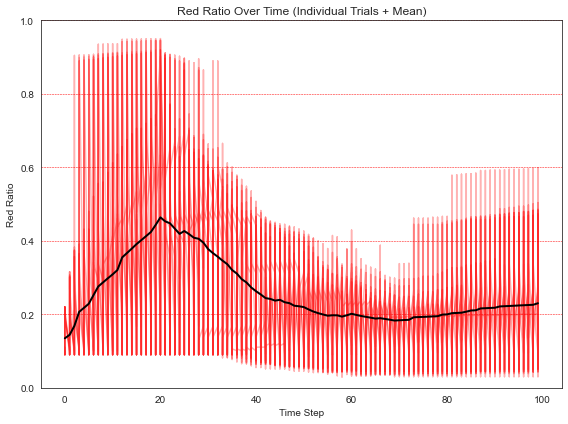

In [130]:
mean_df = df_results.groupby("step")["red_ratio"].mean().reset_index()

plt.figure(figsize=(8,6))

for trial_id in df_results["trial"].unique():
    sub = df_results[df_results["trial"]==trial_id]
    plt.plot(sub["step"], sub["red_ratio"], alpha=0.3, color="red")

plt.plot(mean_df["step"], mean_df["red_ratio"], color="black", linewidth=2, label="Mean")
plt.title("Red Ratio Over Time (Individual Trials + Mean)")
plt.ylim(0,1)
plt.xlabel("Time Step")
plt.ylabel("Red Ratio")
sns.set_style("white") 
plt.grid(axis='y', linestyle='--', color='red', linewidth=0.5)
plt.tight_layout()
plt.savefig("overlaid_trials.png", dpi=300)
plt.show()

### Figure X: Overlaid lines for each of the 10 trials (faint red) alongside the bold black mean. This reveals 
### the range of possible paths the system may take under random conditions.

In [133]:
def make_key_step_table(df, steps=[0, 10, 20, 30, 39]):
    subset = df[df["step"].isin(steps)]
    grouped = subset.groupby("step")["red_ratio"].agg(["mean","std"]).reset_index()
    return grouped

key_steps = range(20,70)
table_df = make_key_step_table(df_results, key_steps)
print(table_df)
print(table_df.to_markdown(index=False))

    step      mean       std
0     20  0.463939  0.245001
1     21  0.453069  0.221306
2     22  0.447843  0.203150
3     23  0.433340  0.187510
4     24  0.419072  0.173269
5     25  0.426775  0.168023
6     26  0.418241  0.155183
7     27  0.408502  0.159747
8     28  0.405660  0.158393
9     29  0.394997  0.154166
10    30  0.377415  0.152992
11    31  0.366497  0.156312
12    32  0.356802  0.157318
13    33  0.346150  0.156521
14    34  0.336422  0.156083
15    35  0.320603  0.155984
16    36  0.310851  0.155577
17    37  0.295814  0.154475
18    38  0.286841  0.153304
19    39  0.273114  0.151170
20    40  0.262906  0.147614
21    41  0.254004  0.144071
22    42  0.244152  0.140169
23    43  0.241954  0.137197
24    44  0.237321  0.136043
25    45  0.239554  0.134341
26    46  0.232877  0.129562
27    47  0.230406  0.126716
28    48  0.223469  0.122442
29    49  0.221934  0.119532
30    50  0.219687  0.115399
31    51  0.213355  0.110288
32    52  0.207592  0.105181
33    53  0.20

In [ ]:
# 1) Compute mean per step
df_mean = df_results.groupby("step")["black_ratio"].mean().reset_index()

plt.figure(figsize=(8,6))

# 2) Plot each trial as a light line
trials_list = df["trial"].unique()
for tr in trials_list:
    sub = df[df["trial"] == tr]
    plt.plot(sub["step"], sub["black_ratio"], alpha=0.3, color="blue")

# 3) Plot the average in bold
plt.plot(df_mean["step"], df_mean["black_ratio"], color="black", linewidth=2, label="Mean")

plt.title("Individual Trials + Mean")
plt.ylim(0, 1)
plt.xlabel("Time Step")
plt.ylabel("Black Ratio")
sns.set_style("white") 
plt.grid(axis='y', linestyle='--', color='blue', linewidth=0.5)
plt.tight_layout()
plt.savefig("individual_trials_mean.png", dpi=300)
plt.show()

In [ ]:
final_df = df[df["step"] == 39]

plt.figure(figsize=(5,6))
sns.boxplot(data=final_df, 
            y="avg_black_ratio")
plt.title("Distribution of Final Black Ratio Across Trials")
plt.ylim(0,1)
plt.ylabel("Black Ratio at Final Timestep")
sns.set_style("white")  
plt.grid(axis='y', linestyle='--', color='black', linewidth=0.5)
plt.tight_layout()
plt.savefig("final_step_boxplot_black.png", dpi=300)
plt.show()

plt.figure(figsize=(5,6))
sns.boxplot(data=final_df, 
            y="avg_red_ratio",
           color="red")
plt.title("Distribution of Final Red Ratio Across Trials")
plt.ylim(0,1)
plt.ylabel("Red Ratio at Final Timestep")
sns.set_style("white") 
plt.grid(axis='y', linestyle='--', color='red', linewidth=0.5)
plt.tight_layout()
plt.savefig("final_step_boxplot_red.png", dpi=300)
plt.show()

# 0. Network Visualization